In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torchvision.transforms import ToTensor, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torchviz import make_dot

In [19]:
train_dataset = MNIST(download=True, root='data', train=True, transform=ToTensor())
train_data = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = MNIST(download=True, root='data', train=False, transform=ToTensor())
test_data = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self, in_features, hidden_features):
      super(AutoEncoder, self).__init__()
      self.encoder = nn.Sequential(
        nn.Linear(in_features, hidden_features),
        nn.ReLU()
      )

      self.decoder = nn.Sequential(
        nn.Linear(hidden_features, in_features),
        nn.ReLU()
      )

    def bottom_up(self, x):
      return self.encoder(x)
    
    def top_down(self, x):
      return self.decoder(x)

In [38]:
criterion = nn.MSELoss()

In [21]:
layers = [
  AutoEncoder(784, 256),
  AutoEncoder(256, 128),
  AutoEncoder(128, 64)
]

In [206]:

for image, labels in train_data:
  image, labels = image.to(device), labels.to(device)

  image = image.flatten(start_dim=1)
  activation = image

  bottom_up_activations = [activation] # How were the layers activated from bottom up?
  top_down_activations = [] # How were the layers activated from top down?

  for layer in layers:
    activation = layer.bottom_up(activation)
    bottom_up_activations.append(activation.clone())

  for layer in layers[::-1]: # Reverse the list
    activation = layer.top_down(activation)
    top_down_activations.append(activation.clone())
  
  top_down_activations.reverse()

  for (bottom_up_activation, top_down_activation) in zip(bottom_up_activations, top_down_activations):
    loss = criterion(top_down_activation, bottom_up_activation)
    loss.backward()

    break
    print(top_down_activation.shape, layers[0].encoder[0].weight.grad.norm())
  
  break

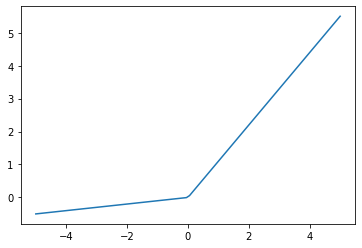

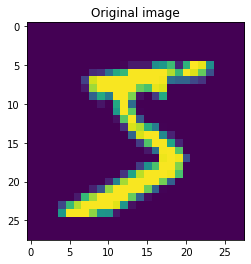

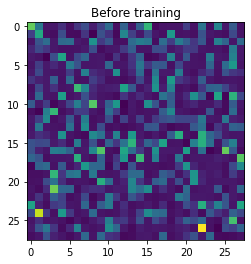

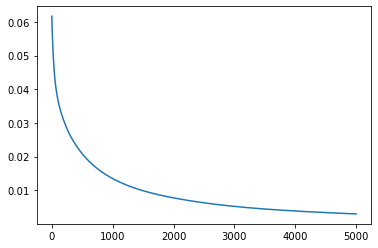

In [22]:
import numpy as np

def relu(x, deriv=False):
  if deriv:
    return 1.0 * (x > 0)
  return x * (x > 0)


def sigmoid(x, deriv=True):
  out = 1.0 / (1.0 + np.exp(-x))
  if deriv:
    return out * (1 - out)
  return out

def leaky_relu(x, deriv=False):
  factor = ((x > 0) + 0.1)
  if deriv:
    return factor
  return factor * x

xs = np.linspace(-5, 5, 100)
ys = leaky_relu(xs)
plt.plot(xs, ys)
plt.show()

activation = leaky_relu

in_features = 28*28
out_features = 512

# He initialization?
W1 = (np.random.random((out_features, in_features)) * 2 - 1) * 2/np.sqrt(in_features) 
W2 = (np.random.random((in_features, out_features)) * 2 - 1) * 2/np.sqrt(in_features) 
b1 = np.zeros(out_features)
b2 = np.zeros(in_features)

image = next(iter(train_data))[0]
x = image.flatten(start_dim=1).numpy()

z1 = x @ W1.T
a1 = activation(z1)
z2 = a1 @ W2.T
a2 = activation(z2)

plt.title("Original image")
plt.imshow(x[0].reshape((28, 28)))
plt.show()

plt.title("Before training")
plt.imshow(a2[0].reshape((28, 28)))
plt.show()

loss_history = []

for i in range(5000):
  # Forward pass
  z1 = x @ W1.T
  a1 = activation(z1)
  z2 = a1 @ W2.T
  a2 = activation(z2)

  # Calculate loss
  loss = (0.5 * (a2 - x)**2).mean()
  loss_history.append(loss)

  # Backward pass
  dEda2 = a2 - x
  da2dz2 = activation(z2, deriv=True)
  dz2dW2 = a1
  da2dW2 = da2dz2[:, :, None] @ dz2dW2[:, None, :]
  dEdW2 = (da2dW2.T * dEda2.T).T

  # Gradient step
  W2 -= 1e-3 * dEdW2.mean(axis=0)

plt.plot(loss_history)
plt.show()


/var/folders/vs/ylfhyw117z1g5xvn55z8jr3c0000gp/T/ipykernel_17615/90959988.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2)


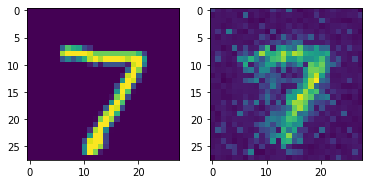

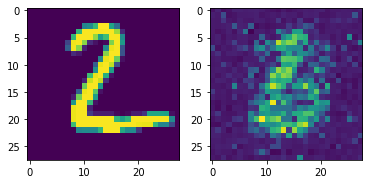

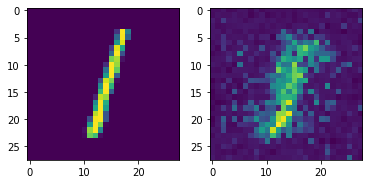

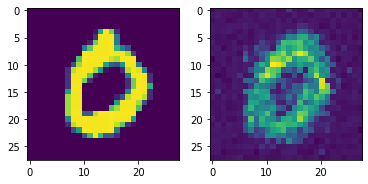

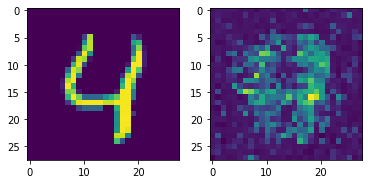

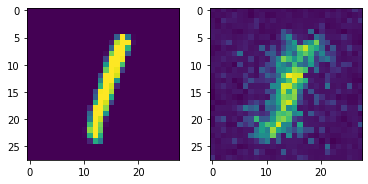

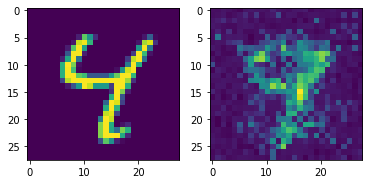

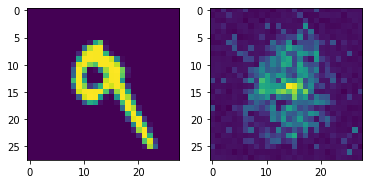

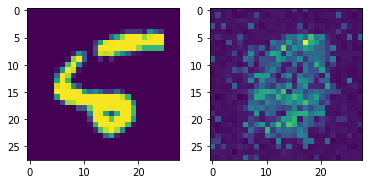

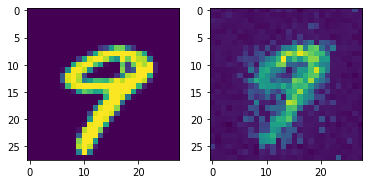

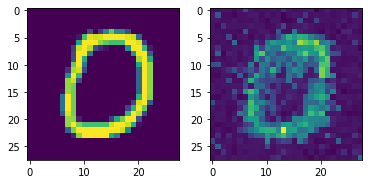

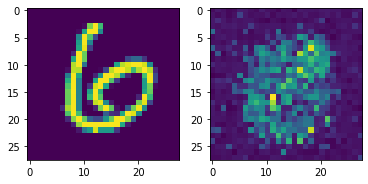

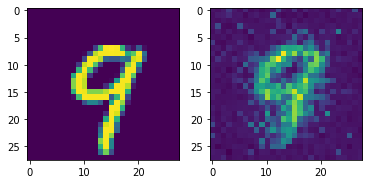

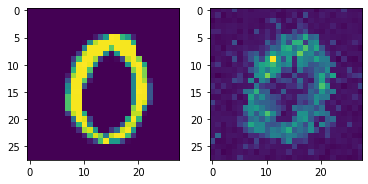

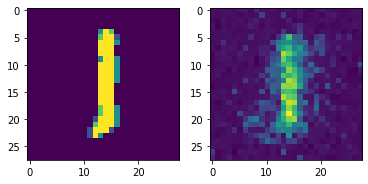

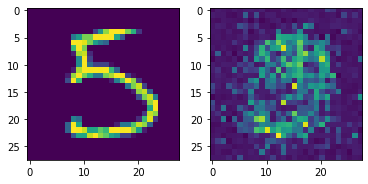

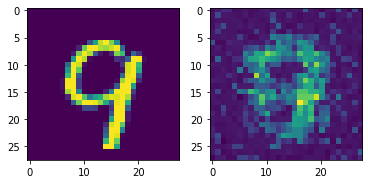

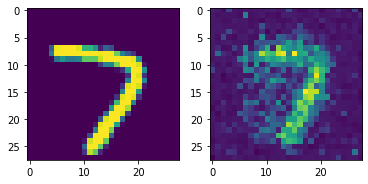

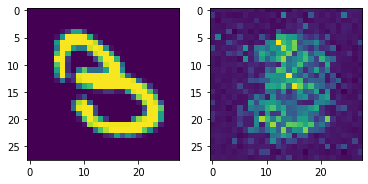

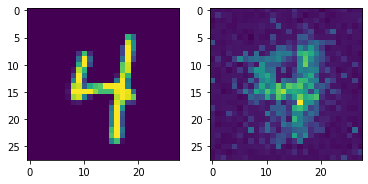

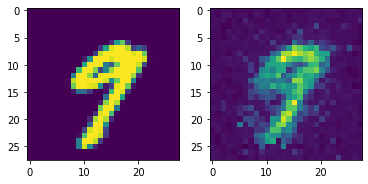

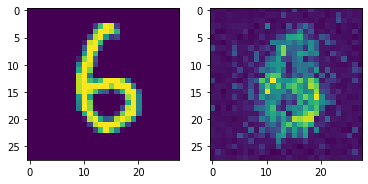

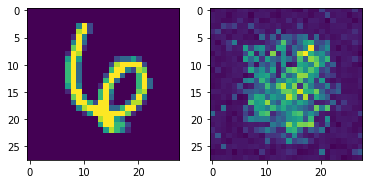

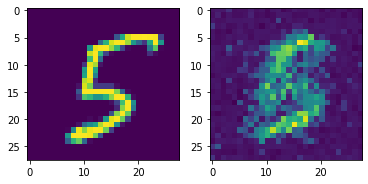

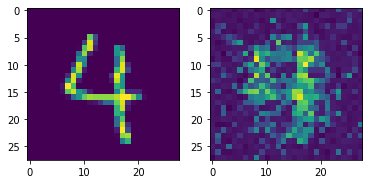

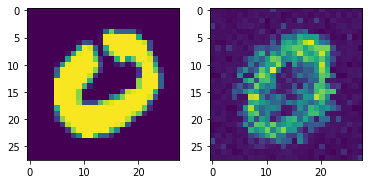

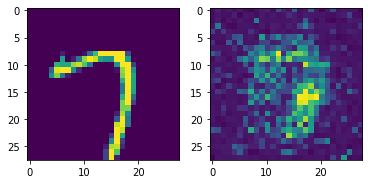

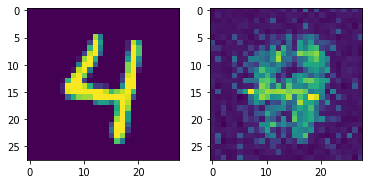

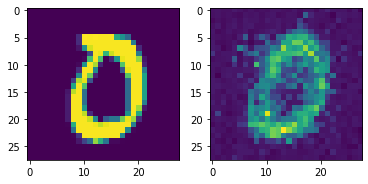

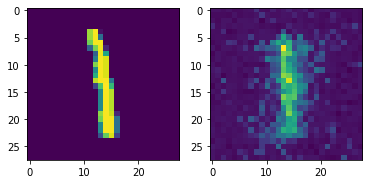

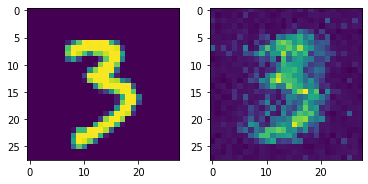

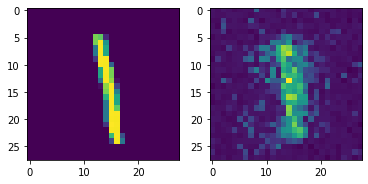

In [21]:
image = next(iter(test_data))[0]
x = image.flatten(start_dim=1).numpy()

z1 = x @ W1.T
a1 = activation(z1)
z2 = a1 @ W2.T
a2 = activation(z2)

for original, reconstruction in zip(x, a2):
  fig, axs = plt.subplots(1, 2)

  #plt.title("Original")
  axs[0].imshow(original.reshape((28, 28)))
  #plt.show()

  #plt.title("Reconstruction")
  axs[1].imshow(reconstruction.reshape((28, 28)))
  #plt.show()